In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. Read data

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


### 2. Text Preprocessing

In [4]:
# convert positive to 1 and negative to 0
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_num = ordinal_encoder.fit_transform(df[['sentiment']])
df['num_sentiment'] = df_num

In [5]:
df.drop(['sentiment'], axis=1, inplace=True)

In [6]:
df.head(2)

,review,num_sentiment
0,One of the other reviewers has mentioned that ...,1.0
1,A wonderful little production. <br /><br />The...,1.0


In [7]:
# Remove html coding
df['review'] = df['review'].str.replace('<.*?>','')

In [8]:
# Remove all puncuation and symbols
df['review'] = df['review'].str.replace('[^\w\s]','')

In [9]:
# Make everything lower case
df['review'] = df['review'].str.lower()

#### 2.1 Data without Removing Stopwords

In [10]:
df_wosw = df.copy()

In [11]:
# Tokenize
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [12]:
def lemmatize_text(text):
    
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [13]:
df_wosw['lemma_review'] = df_wosw.review.apply(lemmatize_text)

In [14]:
df_wosw.head(2)

,review,num_sentiment,lemma_review
0,one of the other reviewers has mentioned that ...,1.0,one of the other reviewer ha mentioned that af...
1,a wonderful little production the filming tech...,1.0,a wonderful little production the filming tech...


#### 2.2 Removing Stopwords

In [15]:
# Remove stop words
import spacy

sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
# # After seeing the word counts, update stop words
sp.Defaults.stop_words |= {'movie', 'film'}

In [16]:
all_stopwords.remove('not')

In [17]:
df_wosw['review'] = df_wosw['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

In [18]:
df_wosw['lemma_review'] = df_wosw.review.apply(lemmatize_text)

In [19]:
df_wosw.head(2)

,review,num_sentiment,lemma_review
0,reviewers mentioned watching 1 oz episode youl...,1.0,reviewer mentioned watching 1 oz episode youll...
1,wonderful little production filming technique ...,1.0,wonderful little production filming technique ...


In [20]:
# keep 80% for the training set and 20% the test set.
from sklearn.model_selection import train_test_split

features = df_wosw.drop(['num_sentiment', 'review'], axis=1)
label = df_wosw['num_sentiment']

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.20, random_state=42)

print("Data distribution:\n- Train: {} \n- Test: {}".format(len(X_train),len(X_test)))

Data distribution:
- Train: 40000 
- Test: 10000


In [21]:
# Reset the index in X_train so we can get the mean of review length for the training set
X_train.reset_index(drop=True, inplace=True)

### tensorflow stuff

In [22]:
tokenizer = Tokenizer(num_words=5000, filters='', lower=False, split=' ')
tokenizer.fit_on_texts(X_train['lemma_review'])

In [23]:
X_train = tokenizer.texts_to_sequences(X_train['lemma_review'])
X_test = tokenizer.texts_to_sequences(X_test['lemma_review'])

In [24]:
vocab_size = len(tokenizer.word_index) + 1
max_length = 100

In [25]:
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [27]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Modeling

In [28]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

METRICS = ['accuracy', Precision(name='precision'), Recall(name='recall')]

opt = Adam(learning_rate=0.001, epsilon=1e-6)

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          18193000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 18,310,377
Trainable params: 117,377
Non-trainable params: 18,193,000
_________________________________________________________________
None


## Train - val_split = .2, epochs=10, batch_size=128, optimizer=Adam: learn_rate=.001 decay=1e-6
* GLoVe embeddings

In [30]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 30s 113ms/step - loss: 0.5846 - accuracy: 0.6681 - precision: 0.6821 - recall: 0.6136 - val_loss: 0.4184 - val_accuracy: 0.8089 - val_precision: 0.8401 - val_recall: 0.7630
Epoch 2/10
250/250 [==============================] - 27s 106ms/step - loss: 0.4185 - accuracy: 0.8110 - precision: 0.8077 - recall: 0.8151 - val_loss: 0.3803 - val_accuracy: 0.8407 - val_precision: 0.8255 - val_recall: 0.8643
Epoch 3/10
250/250 [==============================] - 27s 107ms/step - loss: 0.3792 - accuracy: 0.8326 - precision: 0.8316 - recall: 0.8328 - val_loss: 0.3605 - val_accuracy: 0.8414 - val_precision: 0.7970 - val_recall: 0.9160
Epoch 4/10
250/250 [==============================] - 27s 106ms/step - loss: 0.3458 - accuracy: 0.8532 - precision: 0.8513 - recall: 0.8569 - val_loss: 0.3843 - val_accuracy: 0.8434 - val_precision: 0.8934 - val_recall: 0.7797
Epoch 5/10
250/250 [==============================] - 27s 107ms/step - loss: 0.3370 - accura

In [31]:
# Save model
model.save('IMDB_9.h5')

In [32]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 5s 15ms/step - loss: 0.3293 - accuracy: 0.8605 - precision: 0.8723 - recall: 0.8472


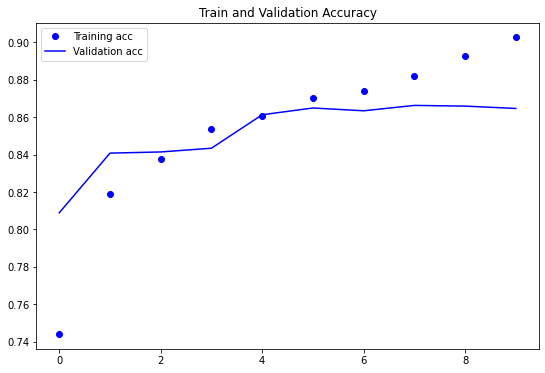

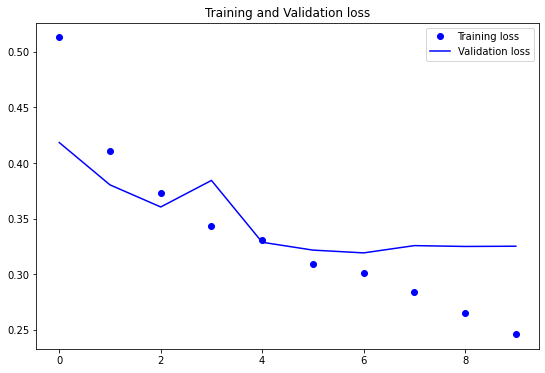

In [35]:
plt.figure(figsize=(9,6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.figure(figsize=(9,6))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()